In [1]:
%load_ext autoreload
%autoreload 2
import sys

# instead of creating a package using setup.py or building from a docker/singularity file,
# import the sister directory of src code to be called on in notebook.
# This keeps the notebook free from code to only hold visualizations and is easier to test
# It also helps keep the state of variables clean such that cells aren't run out of order with a mysterious state
sys.path.append("..")

In [2]:
# from data import hrrr_data, nam_data
import pandas as pd
import numpy as np
from datetime import timedelta
import os
import matplotlib.pyplot as plt
import gc
import matplotlib.dates as mdates
from datetime import datetime

In [3]:
radiometer_df = pd.read_csv(
    "/home/aevans/nwp_bias/src/machine_learning/notebooks/data/radiometer_network.csv"
)
radiometer_df

,STID,NAME,LAT (DEG),LON (DEG),ELEVATION,COUNTY,COMMISSION DATE,TIME (UTC)
0,PROF_ALBA,Albany,42.75175,-73.81128,83.07,Albany,2017-09-01,00:00:00
1,PROF_BELL,Belleville,43.78823,-76.11765,152.10,Jefferson,2017-03-03,00:00:00
2,PROF_BRON,Bronx,40.87248,-73.89352,59.31,Bronx,2017-09-12,22:00:00
3,PROF_BUFF,Buffalo,42.99359,-78.79461,185.39,Erie,2017-03-29,NaN
4,PROF_CHAZ,Chazy,44.88900,-73.46634,74.29,Clinton,2017-03-02,NaN
5,PROF_CLYM,Clymer,42.02143,-79.62746,457.45,Chautauqua,2017-03-22,20:00:00
6,PROF_EHAM,East Hampton,40.97039,-72.20094,22.97,Suffolk,2017-04-27,NaN
7,PROF_JORD,Jordan,43.06874,-76.46999,129.46,Onondaga,2016-11-21,NaN
8,PROF_OWEG,Owego,42.02493,-76.25307,464.45,Tioga,2017-05-02,19:00:00
9,PROF_QUEE,Queens,40.73433,-73.81585,52.89,Queens,2017-06-09,19:00:00


In [4]:
img = "/home/aevans/nwp_bias/src/machine_learning/data/profiler_images/2018/PROF_ALBA/PROF_ALBA_2018_010100.npy"

In [5]:
image = np.load(img).astype(np.float32)

In [6]:
image.shape

(121, 6, 11)

In [11]:
image[:, 0]

array([ 14.137517,  13.982518,  13.827519, ..., -18.91627 , -19.396936,
       -19.89503 ], dtype=float32)

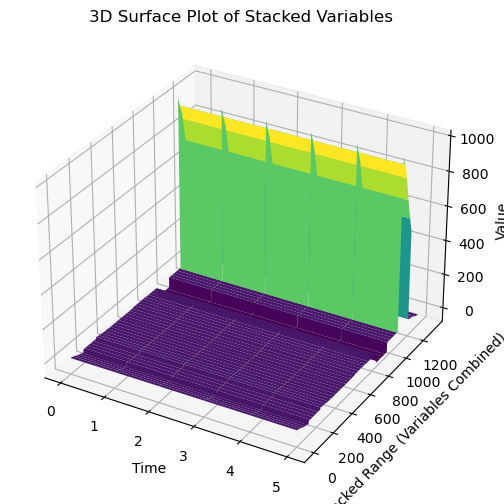

In [21]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection="3d")

X = np.arange(image.shape[1])  # Time bins
Y = np.arange(image.shape[0])  # Stacked variables/ranges
X, Y = np.meshgrid(X, Y)
Z = image  # Values

ax.plot_surface(X, Y, Z, cmap="viridis")

ax.set_title("3D Surface Plot of Stacked Variables")
ax.set_xlabel("Time")
ax.set_ylabel("Stacked Range (Variables Combined)")
ax.set_zlabel("Value")
plt.show()

In [12]:
nysm_clim = pd.read_csv("/home/aevans/nwp_bias/src/landtype/data/nysm.csv")
nysm_clim

,stid,number,name,lat [degrees],lon [degrees],elevation [m],county,nearest_city,state,distance_from_town [km],direction_from_town [degrees],climate_division,climate_division_name,wfo,commissioned,decommissioned
0,ADDI,107,Addison,42.040360,-77.237260,507.6140,Steuben,Addison,NY,6.9,S,1,Western Plateau,BGM,2016-08-10 18:15:00 UTC,NaN
1,ANDE,111,Andes,42.182270,-74.801390,518.2820,Delaware,Andes,NY,1.5,WSW,2,Eastern Plateau,BGM,2016-08-04 15:55:00 UTC,NaN
2,BATA,24,Batavia,43.019940,-78.135660,276.1200,Genesee,Batavia,NY,4.9,ENE,9,Great Lakes,BUF,2016-02-18 18:40:00 UTC,NaN
3,BEAC,76,Beacon,41.528750,-73.945270,90.1598,Dutchess,Beacon,NY,3.3,NE,5,Hudson Valley,ALY,2016-08-22 16:45:00 UTC,NaN
4,BELD,90,Belden,42.223220,-75.668520,470.3700,Broome,Belden,NY,2.2,NNE,2,Eastern Plateau,BGM,2015-11-30 20:20:00 UTC,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,WFMB,14,Whiteface Mountain Base,44.393236,-73.858829,614.5990,Essex,Wilmington,NY,3.5,W,3,Northern Plateau,BTV,2016-01-29 20:55:00 UTC,NaN
122,WGAT,123,Woodgate,43.532408,-75.158597,442.9660,Oneida,Woodgate,NY,1.4,NNW,3,Northern Plateau,BGM,2016-08-29 18:20:00 UTC,NaN
123,WHIT,10,Whitehall,43.485073,-73.423071,36.5638,Washington,Whitehall,NY,8.0,S,7,Champlain Valley,ALY,2015-08-26 20:30:00 UTC,NaN
124,WOLC,79,Wolcott,43.228680,-76.842610,121.2190,Wayne,Wolcott,NY,2.4,WNW,9,Great Lakes,BUF,2016-03-09 18:10:00 UTC,NaN


In [13]:
gfs = pd.read_parquet(
    "/home/aevans/nwp_bias/src/machine_learning/data/gfs_data/fh009/GFS_2018_08_direct_compare_to_nysm_sites_mask_water.parquet"
)

In [14]:
gfs.columns

Index(['latitude', 'longitude', 't2m', 'sh2', 'd2m', 'r2', 'u10', 'v10',
       'u_total', 'u_dir', 'tp', 'prmsl', 'orog', 'tcc', 'cape', 'cin',
       'dswrf', 'dlwrf', 'gh', 'station', 'valid_time', 'index', 'lead time',
       'landn', 'time', 'station_prev_fh', 't2m_prev_fh', 'sh2_prev_fh',
       'd2m_prev_fh', 'r2_prev_fh', 'u10_prev_fh', 'v10_prev_fh',
       'prmsl_prev_fh', 'orog_prev_fh', 'tcc_prev_fh', 'cape_prev_fh',
       'cin_prev_fh', 'dswrf_prev_fh', 'dlwrf_prev_fh', 'gh_prev_fh',
       'u_total_prev_fh', 'u_dir_prev_fh', 'lead time_prev_fh',
       'landn_prev_fh'],
      dtype='object')

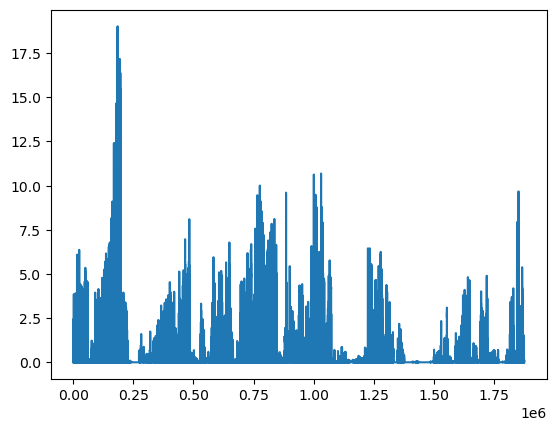

In [15]:
plt.plot(gfs["tp"])

In [ ]:
df = pd.read_parquet(
    "/home/aevans/nwp_bias/src/machine_learning/data/lstm_eval_csvs/20250107/VOOR/01_07_2025_14:58:37_full_VOOR.parquet"
)
for k in df.columns:
    print(k)

In [ ]:
df["diff"] = df[f"tp_VOOR"] - df[f"precip_total_VOOR"]

In [ ]:
def date_filter(ldf, time1, time2):
    ldf = ldf[ldf["valid_time"] > time1]
    ldf = ldf[ldf["valid_time"] < time2]

    return ldf

In [ ]:
time1 = datetime(2024, 1, 1, 0, 0, 0)
time2 = datetime(2024, 1, 31, 23, 0, 0)

df = date_filter(df, time1, time2)

In [ ]:
def met_output(df, station, fh):
    fig, ax = plt.subplots(figsize=(24, 6))
    x = df["valid_time"]

    # Convert datetime values to numerical values
    x_numeric = mdates.date2num(x)

    # Assuming your timestamps are in a datetime64 format
    day_mask = (x.dt.hour >= 6) & (
        x.dt.hour < 18
    )  # Adjust the hours based on your day/night definition

    plt.plot(
        np.array(x),
        np.array(df[f"u_total_{station}"]),
        c="mediumseagreen",
        linewidth=3,
        label="NAM Prediction",
    )

    plt.plot(
        np.array(x),
        np.array(df[f"wspd_sonic_mean_{station}"]),
        c="black",
        linewidth=1,
        alpha=0.9,
        label="NYSM Observation",
    )

    # Fill daytime hours with white color
    ax.fill_between(
        x_numeric, 0, 10, where=day_mask, color="white", alpha=0.5, label="Daytime"
    )

    # Fill nighttime hours with grey color
    ax.fill_between(
        x_numeric, 0, 10, where=~day_mask, color="grey", alpha=0.2, label="Nighttime"
    )

    ax.set_title(f"NAM Prediction v NYSM Observation: {station}: FH{fh}", fontsize=28)
    # plt.ylim(-5, 5.)
    ax.legend()
    plt.show()

In [ ]:
met_output(df, "VOOR", 1)

In [ ]:
nysm_clim = pd.read_csv("/home/aevans/nwp_bias/src/landtype/data/nysm.csv")
clim_div = nysm_clim["climate_division_name"].unique()
nysm_clim

In [ ]:
# nysm_clim = nysm_clim[nysm_clim["climate_division_name"] == "Hudson Valley"]
# nysm_clim

In [ ]:
parq = pd.read_parquet(
    "/home/aevans/nwp_bias/src/machine_learning/data/AMS_2025/20250102/BKLN/BKLN_fh3_t2m_GFS_ml_output_og.parquet"
)
parq

In [ ]:
parq

In [ ]:
plt.plot(parq["target_error"])

In [ ]:
df = pd.read_csv(
    "/home/aevans/nwp_bias/src/machine_learning/data/parent_models/GFS/s2s/Western Plateau_t2m_GFS_lookup_linear.csv"
)
df

In [ ]:
df1 = pd.read_csv(
    "/home/aevans/nwp_bias/src/machine_learning/data/parent_models/HRRR/s2s/Central Lakes_u_total_HRRR_lookup_quad.csv"
)
# df = df[df["station"] == "ADDI"]
df1

In [ ]:
# Group by 'station' and set 'fh' as the index
df_grouped = df.groupby("station").apply(lambda x: x.set_index("forecast_hour"))

# # Optionally, reset the index to avoid multi-level indexing from `groupby().apply()`
# df_grouped = df_grouped.reset_index(level=0, drop=True)

# Display the DataFrame
df_grouped

In [ ]:
nysm_clim = pd.read_csv("/home/aevans/nwp_bias/src/landtype/data/nysm.csv")
nysm_clim[nysm_clim["climate_division_name"] == "Eastern Plateau"]

In [ ]:
def get_more_fh(fh, station, var, times):
    hrrr_df_0 = hrrr_data.read_hrrr_data(str(fh + 2).zfill(2))
    hrrr_df_1 = hrrr_data.read_hrrr_data(str(fh + 4).zfill(2))

    hrrr_df_0 = hrrr_df_0[hrrr_df_0["station"] == station]
    hrrr_df_1 = hrrr_df_1[hrrr_df_1["station"] == station]

    hrrr_df_0 = hrrr_df_0[["valid_time", var]]
    hrrr_df_1 = hrrr_df_1[["valid_time", var]]

    # Create a DataFrame for valid times
    df = pd.DataFrame({"valid_time": times})
    df = df.merge(hrrr_df_0, on="valid_time", suffixes=(None, f"_{station}_+2"))
    df = df.merge(hrrr_df_1, on="valid_time", suffixes=(None, f"_{station}_+4"))
    df = df.rename(columns={"t2m": f"{var}_{station}_+2"})
    # df.fillna(-999, inplace=True)

    fh2 = df[f"{var}_{station}_+2"].values
    fh4 = df[f"{var}_{station}_+4"].values

    print(len(fh2))
    print(len(fh4))

    return fh2, fh4

In [ ]:
def read_nam_data(fh):
    """
    Reads and concatenates parquet files containing forecast and error data for HRRR weather models
    for the years 2018 to 2022.

    Returns:
        pandas.DataFrame: of hrrr weather forecast information for each NYSM site.
    """

    years = ["2022", "2023", "2024"]
    savedir = f"/home/aevans/nwp_bias/src/machine_learning/data/nam_data/fh{fh}/"

    # create empty lists to hold dataframes for each model
    nam_fcast_and_error = []

    # loop over years and read in parquet files for each model
    for year in years:
        for month in np.arange(1, 13):
            str_month = str(month).zfill(2)
            if (
                os.path.exists(
                    f"{savedir}NAM_{year}_{str_month}_direct_compare_to_nysm_sites_mask_water.parquet"
                )
                == True
            ):
                print(
                    f"{savedir}NAM_{year}_{str_month}_direct_compare_to_nysm_sites_mask_water.parquet"
                )
                nam_fcast_and_error.append(
                    pd.read_parquet(
                        f"{savedir}NAM_{year}_{str_month}_direct_compare_to_nysm_sites_mask_water.parquet"
                    )
                )
            else:
                continue
            gc.collect()

    # concatenate dataframes for each model
    nam_fcast_and_error_df = pd.concat(nam_fcast_and_error)
    nam_fcast_and_error_df = nam_fcast_and_error_df.dropna()

    # return dataframes for each model
    return nam_fcast_and_error_df

In [ ]:
def read_gfs_data(fh):
    """
    Reads and concatenates parquet files containing forecast and error data for HRRR weather models
    for the years 2018 to 2022.

    Returns:
        pandas.DataFrame: of hrrr weather forecast information for each NYSM site.
    """

    years = ["2018", "2019", "2020", "2021", "2022", "2023"]
    savedir = f"/home/aevans/nwp_bias/src/machine_learning/data/gfs_data/fh{fh}/"

    # create empty lists to hold dataframes for each model
    gfs_fcast_and_error = []

    # loop over years and read in parquet files for each model
    for year in years:
        print("compiling", year)
        for month in np.arange(1, 13):
            print(month)
            str_month = str(month).zfill(2)
            if (
                os.path.exists(
                    f"{savedir}GFS_{year}_{str_month}_direct_compare_to_nysm_sites_mask_water.parquet"
                )
                == True
            ):
                gfs_fcast_and_error.append(
                    pd.read_parquet(
                        f"{savedir}GFS_{year}_{str_month}_direct_compare_to_nysm_sites_mask_water.parquet"
                    )
                )
            else:
                continue

    # concatenate dataframes for each model
    gfs_fcast_and_error_df = pd.concat(gfs_fcast_and_error)

    # return dataframes for each model
    return gfs_fcast_and_error_df

In [ ]:
def load_nysm_data():
    """
    Load and concatenate NYSM (New York State Mesonet) data from parquet files.

    NYSM data is resampled at 1-hour intervals and stored in separate parquet files
    for each year from 2018 to 2022.

    Returns:
        nysm_1H_obs (pd.DataFrame): A DataFrame containing concatenated NYSM data with
        missing values filled for the 'snow_depth' column.

    This function reads NYSM data from parquet files, resamples it to a 1-hour interval,
    and concatenates the data from multiple years. Missing values in the 'snow_depth'
    column are filled with -999, and any rows with missing values are dropped before
    returning the resulting DataFrame.

    Example:
    ```
    nysm_data = load_nysm_data()
    print(nysm_data.head())
    ```

    Note: Ensure that the parquet files are located in the specified path before using this function.
    """
    # Define the path where NYSM parquet files are stored.
    nysm_path = "/home/aevans/nwp_bias/data/nysm/"

    # Initialize an empty list to store data for each year.
    nysm_1H = []

    # Loop through the years from 2018 to 2022 and read the corresponding parquet files.
    for year in np.arange(2024, 2025):
        df = pd.read_parquet(f"{nysm_path}nysm_1H_obs_{year}.parquet")
        df.reset_index(inplace=True)
        nysm_1H.append(df)

    # Concatenate data from different years into a single DataFrame.
    nysm_1H_obs = pd.concat(nysm_1H)

    # Fill missing values in the 'snow_depth' column with -999.
    nysm_1H_obs["snow_depth"].fillna(-999, inplace=True)
    # Fill missing values in the 'snow_depth' column with -999.
    nysm_1H_obs["ta9m"].fillna(-999, inplace=True)

    # if nysm_1H_obs['ta9m'].isna().mean() > 0.8:
    #     nysm_1H_obs.drop('ta9m', axis=1, inplace=True)

    nysm_1H_obs.dropna(inplace=True)

    return nysm_1H_obs

In [ ]:
nam_df = pd.read_parquet(
    "/home/aevans/nwp_bias/src/machine_learning/data/GFS_data/fh003/GFS_2018_01_direct_compare_to_nysm_sites_mask_water.parquet"
)

In [ ]:
sorted(nam_df["station"].unique())

In [ ]:
df = load_nysm_data()

# df = pd.read_csv("/home/aevans/nwp_bias/src/landtype/data/nysm.csv")

# stations_ls = ['MANH', 'VOOR', 'HERK', 'ANDE', 'BUFF', 'SCIP', 'GROV', 'LOUI', 'ESSX', 'GABR']

In [ ]:
nysm_df = 

In [ ]:
gfs = read_gfs_data("009")

In [ ]:
gfs

In [ ]:
lons = df["lon [degrees]"].values
lats = df["lat [degrees]"].values

In [ ]:
df

In [ ]:
df = df[df["stid"].isin(stations_ls)]
df = df[["lat [degrees]", "lon [degrees]"]]

In [ ]:
# df.to_csv("/home/aevans/nwp_bias/src/landtype/data/first_paper_stations_coords.csv")

In [ ]:
# import gc

# gfs_df = read_gfs_data("006")

In [ ]:
# gfs_df["station"].unique()

In [ ]:
fh = 6
station = "SOUT"
var = "t2m"

In [ ]:
df = pd.read_parquet(
    "/home/aevans/nwp_bias/src/machine_learning/data/nam_data/fh001/NAM_2022_04_direct_compare_to_nysm_sites_mask_water.parquet"
)
df

In [ ]:
nam_df = read_nam_data(str(fh).zfill(3))

In [ ]:
# hrrr_df = hrrr_data.read_hrrr_data(str(fh).zfill(2))

# # Filter NYSM data to match valid times from HRRR data
# mytimes = hrrr_df["valid_time"].tolist()
# fh2_, fh4_ = get_more_fh(fh, station, var, mytimes)

In [ ]:
# len(mytimes)

In [ ]:
a100_mae = [
    0.07,
    0.17,
]
a100_mse = [
    0.07,
    0.22,
]
a100_batch = [
    1000,
    5000,
]
a100_gpu = [8, 30]
a100_runtime = [
    timedelta(seconds=24, minutes=16, hours=0),
    timedelta(seconds=5, minutes=16, hours=0),
]

In [ ]:
gh200_mae = [0.06, 0.06]
gh200_mse = [0.06, 0.07]
gh200_batch = [1000, 10000]
gh200_gpu = [8, 64]
gh200_runtime = [
    timedelta(seconds=22, minutes=6, hours=0),
    timedelta(seconds=51, minutes=6, hours=0),
]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import timedelta


def plot_runtime_bar_chart(a100_batch, a100_run_time):
    # Convert timedelta objects to total minutes
    run_time_minutes = [rt.total_seconds() / 60 for rt in a100_run_time]

    # Create the plot
    fig, ax = plt.subplots()

    # Plot the bar chart
    ax.bar(a100_batch, run_time_minutes, 1000, color="orange", label="Run Time")

    # Adding scatter points with large X markers on top of bars
    # ax.scatter(a100_batch, run_time_minutes, color='red', marker='x', s=100, label='Run Time Points')

    # Adding labels and title
    ax.set_xlabel("Batch Size")
    ax.set_ylabel("Run Time (minutes)")
    ax.set_title("Run Time by Batch Size gh200")

    # Display the plot
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


def plot_metrics_bar(a100_mae, a100_mse, a100_batch):
    # Number of bars
    n = len(a100_mae)

    # Create an array for the positions of the bars
    bar_width = 0.35
    index = np.arange(n)

    # Plotting the bars
    fig, ax = plt.subplots()
    bar1 = ax.bar(
        index,
        a100_mae,
        bar_width,
    )
    # bar2 = ax.bar(index + bar_width, a100_mse, bar_width, label='MSE')

    # Adding labels and title
    ax.set_xlabel("Batch Size")
    ax.set_ylabel("GPU Memory")
    ax.set_ylim(0, 90)
    ax.set_title("GPU Memory by Batch Size for a100")
    ax.set_xticks(index)
    ax.set_xticklabels(a100_batch)
    ax.legend()

    # Display the plot
    plt.show()

In [ ]:
plot_runtime_bar_chart(a100_batch, a100_runtime)

In [ ]:
plot_runtime_bar_chart(gh200_batch, gh200_runtime)

In [ ]:
plot_metrics_bar(a100_gpu, a100_mse, a100_batch)

In [ ]:
plot_metrics_bar(gh200_gpu, gh200_mse, gh200_batch)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cartopy.crs as crs
import cartopy.feature as cfeature

color_dict = {
    0: "cyan",
    1: "blue",
    2: "yellow",
    3: "green",
    # 4: 'red',
    # 5: 'orange',
    # 6: 'purple',
    # 7: 'black',
    # 8: 'white'
}


def plurality_plot(df, geovar):
    projPC = crs.PlateCarree()
    latN = df["lat"].max() + 1
    latS = df["lat"].min() - 1
    lonW = df["lon"].max() + 1
    lonE = df["lon"].min() - 1
    cLat = (latN + latS) / 2
    cLon = (lonW + lonE) / 2
    projLcc = crs.LambertConformal(central_longitude=cLon, central_latitude=cLat)

    fig, ax = plt.subplots(
        figsize=(6, 6), subplot_kw={"projection": crs.PlateCarree()}, dpi=400
    )
    ax.set_extent([lonW, lonE, latS, latN], crs=projPC)
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle="--")
    ax.add_feature(cfeature.LAKES, alpha=0.5)
    ax.add_feature(cfeature.STATES)
    ax.xticklabels_top = False
    ax.ylabels_right = False
    ax.gridlines(
        crs=crs.PlateCarree(),
        draw_labels=True,
        linewidth=2,
        color="black",
        alpha=0.5,
        linestyle="--",
    )
    ax.scatter(
        x=df["lon"],
        y=df["lat"],
        c=df["color"],
        s=40,
        marker="o",
        edgecolor="black",
        transform=crs.PlateCarree(),
    )
    ax.set_title(f"Mesonet Site {geovar} Clusters", size=16)
    ax.set_xlabel("Longitude", size=14)
    ax.set_ylabel("Latitude", size=14)
    ax.tick_params(axis="x", labelsize=12)
    ax.tick_params(axis="y", labelsize=12)
    ax.grid()

    # Create legend patches
    legend_patches = [
        mpatches.Patch(color=color, label=f"Category {key}")
        for key, color in color_dict.items()
    ]

    # Add the legend to the plot
    ax.legend(
        handles=legend_patches,
        loc="upper left",  # Use 'upper left' to anchor the legend in the figure
        bbox_to_anchor=(1.1, 1),  # Move the legend outside the plot to the right
        borderaxespad=0,  # Adjust the padding between the legend and the axes
        title="Categories",
    )

    plt.show()

In [ ]:
cluster_df = pd.read_csv("/home/aevans/nwp_bias/src/landtype/data/lstm_clusters.csv")
cluster_df["lon"] = lons
cluster_df["lat"] = lats
cluster_df["color"] = cluster_df["elev_cat"].map(color_dict)
cluster_df

In [ ]:
plurality_plot(cluster_df, "Elevation")

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as crs
import cartopy.feature as cfeature
import numpy as np
import pandas as pd
import random
import matplotlib.patches as mpatches
import matplotlib.image as mpimg
from matplotlib.colors import ListedColormap

In [ ]:
def plot(shapefile_path):
    # Define a list of colors for each shape file
    # colors = list(mcolors.TABLEAU_COLORS.values())
    # projPC = crs.PlateCarree()
    # latN = df["nysm_lat"].max() + 0.5
    # latS = df["nysm_lat"].min() - 0.5
    # lonW = df["nysm_lon"].max() + 0.5
    # lonE = df["nysm_lon"].min() - 0.5
    # cLat = (latN + latS) / 2
    # cLon = (lonW + lonE) / 2
    # projLcc = crs.LambertConformal(central_longitude=cLon, central_latitude=cLat)

    fig, ax = plt.subplots(
        figsize=(9, 15), subplot_kw={"projection": crs.PlateCarree()}
    )
    # ax.legend()
    # # ax.set_extent([lonW, lonE, latS, latN], crs=projPC)
    # ax.add_feature(cfeature.LAND)
    # ax.add_feature(cfeature.COASTLINE)
    # ax.add_feature(cfeature.BORDERS, linestyle="--")
    # ax.add_feature(cfeature.LAKES, alpha=0.5)
    # ax.add_feature(cfeature.STATES)
    # ax.xticklabels_top = False
    # ax.ylabels_right = False
    # ax.gridlines(
    #     crs=crs.PlateCarree(),
    #     draw_labels=True,
    #     linewidth=2,
    #     color="black",
    #     alpha=0.5,
    #     linestyle="--",
    # )

    # plt.scatter(
    #     df["nysm_lon"],
    #     df["nysm_lat"],
    #     c="blue",
    #     s=70,
    #     edgecolors="black",
    #     transform=crs.PlateCarree(),
    #     zorder=5,
    #     label="NYSM Sites",
    # )

    # plt.scatter(
    #     df["nysm_lon"].iloc[0],
    #     df["nysm_lat"].iloc[0],
    #     c="green",
    #     marker="*",
    #     s=400,
    #     edgecolors="black",
    #     transform=crs.PlateCarree(),
    #     zorder=5,
    #     label="Southold",
    # )

    # plt.scatter(
    #     df["hrrr_lon"],
    #     df["hrrr_lat"],
    #     c='orange',
    #     s = 70,
    #     edgecolors='black',
    #     transform=crs.PlateCarree(),
    #     zorder=5,
    #     label='HRRR'
    # )

    # # Annotate each point in NYSM
    # for i, txt in enumerate(df["station"]):
    #     plt.annotate(
    #         txt,
    #         (df["nysm_lon"].iloc[i], df["nysm_lat"].iloc[i]),
    #         textcoords="offset points",
    #         xytext=(5, 10),
    #         ha="center",
    #         fontsize=18,
    #     )

    # Load the shape file using geopandas
    climate_divisions = gpd.read_file(shapefile_path)
    # Plot climate divisions from the shape file
    climate_divisions.plot(
        ax=ax,
        edgecolor="black",
        facecolor="none",
        transform=crs.PlateCarree(),
        zorder=4,
    )

    plt.legend(bbox_to_anchor=(1.1, 1), loc="upper left", borderaxespad=0, fontsize=12)

In [ ]:
path = "/home/aevans/nwp_bias/src/machine_learning/notebooks/data/GIS.OFFICIAL_CLIM_DIVISIONS.shp"

In [ ]:
plot(path)

In [ ]:
nysm_clim

In [ ]:
clim_div = [
    "St. Lawrence Valley",
    "Great Lakes",
    "Northern Plateau",
    "Champlain Valley",
    "Hudson Valley",
    "Mohawk Valley",
    "Western Plateau",
    "Eastern Pleateau",
    "Coastal",
    "Central Lakes",
]

In [ ]:
# clim_div = sorted(clim_div)
image = "/home/aevans/nwp_bias/src/landtype/data/NCEI_logo.png"

In [ ]:
def create_xCITE_gif(nysm_clim, fh, clim_div, logo):
    # Create your dataframe df_
    df_ = nysm_clim.copy()

    # Define colors dictionary and randomly assign colors
    nwp_dict = {0: "green", 1: "red", 2: "blue"}  # NAM  # HRRR  # GFS
    nwps_all = [0, 1, 2]

    # Randomly assign values from nwps_all to the 'lister'
    lister = [random.choice(nwps_all) for _ in df_["stid"]]
    df_["color"] = [nwp_dict[value] for value in lister]

    # Create plot
    fig = plt.figure(figsize=(24, 16))
    ax = fig.add_subplot(
        1,
        1,
        1,
        projection=crs.LambertConformal(
            central_longitude=-75.0, standard_parallels=(49, 77)
        ),
    )

    # Load the shapefile for boundaries
    shapefile_path = "/home/aevans/nwp_bias/src/machine_learning/notebooks/data/GIS.OFFICIAL_CLIM_DIVISIONS.shp"
    gdf = gpd.read_file(shapefile_path)

    ny_state_boundaries_path = "/home/aevans/nwp_bias/src/landtype/data/State.shx"
    ny_state_boundaries_geo = gpd.read_file(ny_state_boundaries_path).to_crs(epsg=4326)

    ny_bbox = ny_state_boundaries_geo.total_bounds
    gdf_filtered = gdf.cx[ny_bbox[0] : ny_bbox[2], ny_bbox[1] : ny_bbox[3]]
    gdf_filtered = gdf_filtered.iloc[20:29]

    # Create a categorical column for plotting
    gdf_filtered["category"] = np.arange(len(gdf_filtered))

    # Plot shapefile with climate divisions (remove the automatic legend)
    gdf_filtered.plot(
        ax=ax,
        transform=crs.PlateCarree(),
        column="category",
        cmap="tab10",
        alpha=0.3,
        legend=False,
    )

    # Create legend for climate divisions using the colors from the 'tab10' colormap and labels from 'clim_div'
    division_patches = [
        mpatches.Patch(
            color=plt.cm.tab10(i / len(gdf_filtered)), alpha=0.3, label=clim_div[i]
        )
        for i in range(len(gdf_filtered))
    ]

    # Add the climate divisions legend
    legend1 = ax.legend(
        handles=division_patches,
        loc="lower right",
        title="Climate Divisions",
        fontsize=12,
    )
    ax.add_artist(legend1)  # Ensure the first legend is added to the plot

    # Set extent for the plot
    ax.set_extent([-75.0, -72.0, 40.0, 44.0], crs=crs.PlateCarree())

    # Add features
    ax.add_feature(cfeature.BORDERS.with_scale("50m"), linestyle=":", zorder=1)
    ax.add_feature(cfeature.STATES.with_scale("50m"), linestyle=":", zorder=1)
    ax.add_feature(cfeature.LAKES.with_scale("50m"), zorder=1)
    ax.gridlines(
        crs=crs.PlateCarree(),
        draw_labels=True,
        linewidth=2,
        color="black",
        alpha=0.5,
        linestyle="--",
    )

    # Annotate scatter points with station IDs
    for i, row in df_.iterrows():
        ax.annotate(
            row["stid"],
            (row["lon [degrees]"], row["lat [degrees]"]),
            textcoords="offset points",
            xytext=(0, 7),
            ha="center",
            fontsize=12,
            color="black",
            transform=crs.PlateCarree(),
        )

    # Plot scatter points
    ax.scatter(
        df_["lon [degrees]"],
        df_["lat [degrees]"],
        c=df_["color"],
        s=250,
        edgecolors="black",
        transform=crs.PlateCarree(),
        zorder=10,
    )

    # Create custom legend for NWP models
    nam_patch = mpatches.Patch(color="green", label="NAM")
    hrrr_patch = mpatches.Patch(color="red", label="HRRR")
    gfs_patch = mpatches.Patch(color="blue", label="GFS")

    # Add second legend to the plot
    ax.legend(
        handles=[nam_patch, hrrr_patch, gfs_patch],
        loc="upper left",
        fontsize=12,
        title="NWP Models",
    )

    # Add plot title
    plt.title(
        f"Predicted Most Accurate Model for Hudson Valley,\n Forecast Hour {fh}",
        fontsize=24,
    )
    # Load and add the logo to the lower left
    logo_img = mpimg.imread(logo)
    ax.figure.figimage(
        logo_img, 50, 50, zorder=20, alpha=0.5
    )  # Adjust (x, y) position as needed

    plt.savefig(f"/home/aevans/nwp_bias/src/landtype/data/xCITE_gif/mockup_fh{fh}.png")
    # Show plot
    plt.show()

In [ ]:
# for i in np.arange(1, 13):
#     create_xCITE_gif(nysm_clim, i, clim_div, image)

In [ ]:
gfs_path = (
    "/home/aevans/nwp_bias/src/machine_learning/data/AMS_2025/GFS_t2m_learners_csvs/"
)

files = os.listdir(gfs_path)

masters = pd.DataFrame()
for f in files:
    gfs1 = pd.read_csv(f"{gfs_path}/{f}")
    masters = pd.concat([gfs1, masters])

learners = masters["station"].unique()
learners

In [ ]:
nysm_clim
nysm_ = nysm_clim.copy()

nysm_ = nysm_.rename(columns={"lat [degrees]": "lat", "lon [degrees]": "lon"})
nysm_

In [ ]:
import pandas as pd
import numpy as np
from sklearn.neighbors import BallTree
from sklearn import preprocessing
from sklearn import utils


def get_closest_stations(nysm_df, neighbors, target_station, nwp_model):
    # Earth's radius in kilometers
    EARTH_RADIUS_KM = 6378

    lats = nysm_df["lat"].unique()
    lons = nysm_df["lon"].unique()

    locations_a = pd.DataFrame()
    locations_a["lat"] = lats
    locations_a["lon"] = lons

    for column in locations_a[["lat", "lon"]]:
        rad = np.deg2rad(locations_a[column].values)
        locations_a[f"{column}_rad"] = rad

    locations_b = locations_a

    ball = BallTree(locations_a[["lat_rad", "lon_rad"]].values, metric="haversine")

    # k: The number of neighbors to return from tree
    k = neighbors
    # Executes a query with the second group. This will also return two arrays.
    distances, indices = ball.query(locations_b[["lat_rad", "lon_rad"]].values, k=k)

    # Convert distances from radians to kilometers
    distances_km = distances * EARTH_RADIUS_KM

    # source info to creare a dictionary
    indices_list = [indices[x][0:k] for x in range(len(indices))]
    distances_list = [distances_km[x][0:k] for x in range(len(distances_km))]
    stations = nysm_df["stid"].unique()

    # create dictionary
    station_dict = {}
    for k, _ in enumerate(stations):
        station_dict[stations[k]] = (indices_list[k], distances_list[k])

    utilize_ls = []
    vals, dists = station_dict.get(target_station)

    if nwp_model == "GFS":
        utilize_ls.append(target_station)
        for v, d in zip(vals, dists):
            if d >= 30 and len(utilize_ls) < 5:
                x = stations[v]
                utilize_ls.append(x)

    if nwp_model == "NAM":
        utilize_ls.append(target_station)
        for v, d in zip(vals, dists):
            if d >= 12 and len(utilize_ls) < 4:
                x = stations[v]
                utilize_ls.append(x)

    if nwp_model == "HRRR":
        for v, d in zip(vals, dists):
            x = stations[v]
            utilize_ls.append(x)

    return utilize_ls

In [ ]:
stations = nysm_clim["stid"].unique()

elev_delta = []

for s in stations:
    print(s)
    utilize_ls = get_closest_stations(nysm_, 15, s, "GFS")
    selection = nysm_[nysm_["stid"].isin(utilize_ls)]
    # Find the maximum value in 'col1'
    max_value = selection["elevation [m]"].max()
    min_value = selection["elevation [m]"].min()
    delta = max_value - min_value
    elev_delta.append(delta)
elev_delta

In [ ]:
def create_gfs_learners(nysm_clim, clim_div, learners):
    """
    Create a GIF frame showing NWP bias correction with stations colored by their inclusion in the learners list.

    Parameters:
    - nysm_clim: DataFrame containing station data.
    - fh: Forecast hour.
    - clim_div: List of climate division names.
    - learners: List of station IDs classified as learners.
    """
    df_ = nysm_clim.copy()

    # Define color mapping based on whether the station is in the learners list
    df_["color"] = ["green" if stid in learners else "black" for stid in df_["stid"]]

    # Create plot
    fig = plt.figure(figsize=(24, 16))
    ax = fig.add_subplot(
        1,
        1,
        1,
        projection=crs.LambertConformal(
            central_longitude=-75.0, standard_parallels=(49, 77)
        ),
    )

    # Load the shapefile for boundaries
    shapefile_path = "/home/aevans/nwp_bias/src/machine_learning/notebooks/data/GIS.OFFICIAL_CLIM_DIVISIONS.shp"
    gdf = gpd.read_file(shapefile_path)

    ny_state_boundaries_path = "/home/aevans/nwp_bias/src/landtype/data/State.shx"
    ny_state_boundaries_geo = gpd.read_file(ny_state_boundaries_path).to_crs(epsg=4326)

    ny_bbox = ny_state_boundaries_geo.total_bounds
    gdf_filtered = gdf.cx[ny_bbox[0] : ny_bbox[2], ny_bbox[1] : ny_bbox[3]]
    subset = pd.concat([gdf_filtered.iloc[20:29], gdf_filtered.iloc[[32]]])
    gdf_filtered = subset.copy()

    # Create a categorical column for plotting
    gdf_filtered["category"] = np.arange(len(gdf_filtered))

    # Plot shapefile with climate divisions (remove the automatic legend)
    gdf_filtered.plot(
        ax=ax,
        transform=crs.PlateCarree(),
        column="category",
        cmap="tab10",
        alpha=0.3,
        legend=False,
    )

    # Create legend for climate divisions using the colors from the 'tab10' colormap and labels from 'clim_div'
    division_patches = [
        mpatches.Patch(
            color=plt.cm.tab10(i / len(gdf_filtered)), alpha=0.3, label=clim_div[i]
        )
        for i in np.arange(0, len(gdf_filtered))
    ]

    # Add the climate divisions legend
    legend1 = ax.legend(
        handles=division_patches,
        loc="lower left",
        title="Climate Divisions",
        fontsize=18,
    )
    legend1.set_title(
        "Climate Divisions", prop={"size": 18}
    )  # Custom font size for the title
    ax.add_artist(legend1)  # Ensure the first legend is added to the plot

    # Set extent for the plot
    ax.set_extent([-80.0, -72.0, 40.0, 45.1], crs=crs.PlateCarree())

    # Add features
    ax.add_feature(cfeature.BORDERS.with_scale("50m"), linestyle=":", zorder=1)
    ax.add_feature(cfeature.STATES.with_scale("50m"), linestyle=":", zorder=1)
    ax.add_feature(cfeature.LAKES.with_scale("50m"), zorder=1)
    ax.gridlines(
        crs=crs.PlateCarree(),
        draw_labels=True,
        linewidth=2,
        color="black",
        alpha=0.5,
        linestyle="--",
    )

    # Annotate scatter points with station IDs
    for i, row in df_.iterrows():
        ax.annotate(
            row["stid"],
            (row["lon [degrees]"], row["lat [degrees]"]),
            textcoords="offset points",
            xytext=(0, 7),
            ha="center",
            fontsize=12,
            color="black",
            transform=crs.PlateCarree(),
        )

    # Plot scatter points
    ax.scatter(
        df_["lon [degrees]"],
        df_["lat [degrees]"],
        c=df_["color"],
        s=250,
        edgecolors="black",
        transform=crs.PlateCarree(),
        zorder=10,
    )

    # Create custom legend for learner status
    learner_patch = mpatches.Patch(color="green", label="Learner")
    non_learner_patch = mpatches.Patch(color="black", label="Non-Learner")

    # Add second legend to the plot
    legend = ax.legend(
        handles=[learner_patch, non_learner_patch],
        loc="upper left",
        fontsize=18,
        title="Station Classification",
    )
    legend.set_title(
        "Station Classification", prop={"size": 18}
    )  # Custom font size for the title

    # Add plot title
    plt.title(
        f"GFS T2M Error : NYSM Stations that Can Learn",
        fontsize=24,
    )

    # # Save the figure
    # plt.savefig(f"/home/aevans/nwp_bias/src/landtype/data/xCITE_gif/mockup_fh{fh}.png")
    # Show plot
    plt.show()

In [ ]:
create_gfs_learners(nysm_clim, clim_div, learners)

In [ ]:
def create_gfs_learners_delta(nysm_clim, clim_div, learners, elev_delta):
    """
    Create a GIF frame showing NWP bias correction with stations colored by their inclusion in the learners list.

    Parameters:
    - nysm_clim: DataFrame containing station data.
    - clim_div: List of climate division names.
    - learners: List of station IDs classified as learners.
    - elev_delta: List containing the elevation delta values to determine scatter point size.
    """
    df_ = nysm_clim.copy()

    # Define color mapping based on whether the station is in the learners list
    df_["color"] = ["green" if stid in learners else "black" for stid in df_["stid"]]

    # Ensure elev_delta is the same length as df_
    if len(elev_delta) != len(df_):
        raise ValueError(
            "Length of elev_delta must match the number of stations in the DataFrame"
        )

    # Create plot
    fig = plt.figure(figsize=(24, 16))
    ax = fig.add_subplot(
        1,
        1,
        1,
        projection=crs.LambertConformal(
            central_longitude=-75.0, standard_parallels=(49, 77)
        ),
    )

    # Load the shapefile for boundaries
    shapefile_path = "/home/aevans/nwp_bias/src/machine_learning/notebooks/data/GIS.OFFICIAL_CLIM_DIVISIONS.shp"
    gdf = gpd.read_file(shapefile_path)

    ny_state_boundaries_path = "/home/aevans/nwp_bias/src/landtype/data/State.shx"
    ny_state_boundaries_geo = gpd.read_file(ny_state_boundaries_path).to_crs(epsg=4326)

    ny_bbox = ny_state_boundaries_geo.total_bounds
    gdf_filtered = gdf.cx[ny_bbox[0] : ny_bbox[2], ny_bbox[1] : ny_bbox[3]]
    subset = pd.concat([gdf_filtered.iloc[20:29], gdf_filtered.iloc[[32]]])
    gdf_filtered = subset.copy()

    # Create a categorical column for plotting
    gdf_filtered["category"] = np.arange(len(gdf_filtered))

    # Plot shapefile with climate divisions (remove the automatic legend)
    gdf_filtered.plot(
        ax=ax,
        transform=crs.PlateCarree(),
        column="category",
        cmap="tab10",
        alpha=0.3,
        legend=False,
    )

    # Create legend for climate divisions using the colors from the 'tab10' colormap and labels from 'clim_div'
    division_patches = [
        mpatches.Patch(
            color=plt.cm.tab10(i / len(gdf_filtered)), alpha=0.3, label=clim_div[i]
        )
        for i in np.arange(0, len(gdf_filtered))
    ]

    # Add the climate divisions legend
    legend1 = ax.legend(
        handles=division_patches,
        loc="lower left",
        title="Climate Divisions",
        fontsize=18,
    )
    legend1.set_title(
        "Climate Divisions", prop={"size": 18}
    )  # Custom font size for the title
    ax.add_artist(legend1)  # Ensure the first legend is added to the plot

    # Set extent for the plot
    ax.set_extent([-80.0, -72.0, 40.0, 45.1], crs=crs.PlateCarree())

    # Add features
    ax.add_feature(cfeature.BORDERS.with_scale("50m"), linestyle=":", zorder=1)
    ax.add_feature(cfeature.STATES.with_scale("50m"), linestyle=":", zorder=1)
    ax.add_feature(cfeature.LAKES.with_scale("50m"), zorder=1)
    ax.gridlines(
        crs=crs.PlateCarree(),
        draw_labels=True,
        linewidth=2,
        color="black",
        alpha=0.5,
        linestyle="--",
    )

    # Annotate scatter points with station IDs
    for i, row in df_.iterrows():
        ax.annotate(
            row["stid"],
            (row["lon [degrees]"], row["lat [degrees]"]),
            textcoords="offset points",
            xytext=(0, 7),
            ha="center",
            fontsize=12,
            color="black",
            transform=crs.PlateCarree(),
        )

    # Plot scatter points with sizes based on 'elev_delta'
    ax.scatter(
        df_["lon [degrees]"],
        df_["lat [degrees]"],
        c=df_["color"],
        s=elev_delta,  # Size of scatter points based on elev_delta
        edgecolors="black",
        transform=crs.PlateCarree(),
        zorder=10,
    )

    # Create custom legend for learner status
    learner_patch = mpatches.Patch(color="green", label="Learner")
    non_learner_patch = mpatches.Patch(color="black", label="Non-Learner")

    # Add second legend to the plot
    legend = ax.legend(
        handles=[learner_patch, non_learner_patch],
        loc="upper left",
        fontsize=18,
        title="Station Classification",
    )
    legend.set_title(
        "Station Classification", prop={"size": 18}
    )  # Custom font size for the title

    # Add plot title
    plt.title(
        f"GFS T2M Error : NYSM Stations that Can Learn",
        fontsize=24,
    )

    # Show plot
    plt.show()

In [ ]:
create_gfs_learners_delta(nysm_clim, clim_div, learners, elev_delta)